<a href="https://colab.research.google.com/github/MillanSharma/Fashion_mnist/blob/main/fashion_mnist_vis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# to prevent unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import cv2
import json
import requests
from tqdm import tqdm

print(tf.__version__)

%matplotlib inline

2.5.0


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\nTrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('Test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))

4423680/4422102 [==============================] - 0s 0us/step

Train_images.shape: (60000, 28, 28), of uint8
Test_images.shape: (10000, 28, 28), of uint8


In [3]:
# reshape for feeding into the model
train_images_gr = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images_gr = test_images.reshape(test_images.shape[0], 28, 28, 1)

print('\nTrain_images.shape: {}, of {}'.format(train_images_gr.shape, train_images_gr.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_gr.shape, test_images_gr.dtype))


Train_images.shape: (60000, 28, 28, 1), of uint8
Test_images.shape: (10000, 28, 28, 1), of uint8


['Ankle boot', 'T-shirt/top', 'T-shirt/top', 'Dress', 'T-shirt/top', 'Pullover', 'Sneaker', 'Pullover', 'Sandal', 'Sandal']


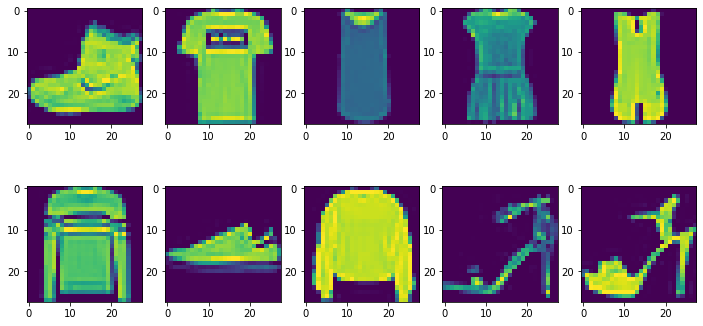

In [5]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
ax[0, 0].imshow(train_images_gr[0].reshape(28,28))
ax[0, 1].imshow(train_images_gr[1].reshape(28,28))
ax[0, 2].imshow(train_images_gr[2].reshape(28,28))
ax[0, 3].imshow(train_images_gr[3].reshape(28,28))
ax[0, 4].imshow(train_images_gr[4].reshape(28,28))
ax[1, 0].imshow(train_images_gr[5].reshape(28,28))
ax[1, 1].imshow(train_images_gr[6].reshape(28,28))
ax[1, 2].imshow(train_images_gr[7].reshape(28,28))
ax[1, 3].imshow(train_images_gr[8].reshape(28,28))
ax[1, 4].imshow(train_images_gr[9].reshape(28,28))

print([class_names[i] for i in train_labels[:10]])

In [12]:
INPUT_SHAPE_RN = (32, 32, 3)

def create_cnn_architecture_model(input_shape):
    inc_net = keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', 
                                                          input_shape=input_shape)
    inc_net.trainable = True
    # Fine-tune the layers
    for layer in inc_net.layers:
        layer.trainable = True
    
    base_inc = inc_net
    base_out = base_inc.output
    pool_out = keras.layers.Flatten()(base_out)
    
    hidden1 = keras.layers.Dense(512, activation='relu')(pool_out)
    drop1 = keras.layers.Dropout(rate=0.3)(hidden1)
    hidden2 = keras.layers.Dense(512, activation='relu')(drop1)
    drop2 = keras.layers.Dropout(rate=0.3)(hidden2)

    out = keras.layers.Dense(10, activation='softmax')(drop2)

    model = keras.Model(inputs=base_inc.input, outputs=out)
    model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-4),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
    return model

In [13]:
model = create_cnn_architecture_model(input_shape=INPUT_SHAPE_RN)
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
_____________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [14]:
train_images_3ch = np.stack([train_images]*3, axis=-1)
test_images_3ch = np.stack([test_images]*3, axis=-1)

print('\nTrain_images.shape: {}, of {}'.format(train_images_3ch.shape, train_images_3ch.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_3ch.shape, test_images_3ch.dtype))


Train_images.shape: (60000, 28, 28, 3), of uint8
Test_images.shape: (10000, 28, 28, 3), of uint8


In [15]:
import cv2

def resize_image_array(img, img_size_dims):
    img = cv2.resize(img, dsize=img_size_dims, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

In [16]:
%%time

IMG_DIMS = (32, 32)

train_images_3ch = np.array([resize_image_array(img, img_size_dims=IMG_DIMS) for img in train_images_3ch])
test_images_3ch = np.array([resize_image_array(img, img_size_dims=IMG_DIMS) for img in test_images_3ch])

print('\nTrain_images.shape: {}, of {}'.format(train_images_3ch.shape, train_images_3ch.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_3ch.shape, test_images_3ch.dtype))


Train_images.shape: (60000, 32, 32, 3), of float32
Test_images.shape: (10000, 32, 32, 3), of float32
CPU times: user 1.58 s, sys: 686 ms, total: 2.26 s
Wall time: 2.27 s


In [19]:
EPOCHS = 15
train_images_3ch_scaled = train_images_3ch / 255.
history = model.fit(train_images_3ch_scaled, train_labels, validation_split=0.2, epochs=EPOCHS)

Epoch 1/15
 265/1500 [====>.........................] - ETA: 1:30 - loss: 0.1172 - accuracy: 0.9698

KeyboardInterrupt: ignored

In [30]:
history.history['loss']

[0.5740717649459839,
 0.32921725511550903,
 0.28050926327705383,
 0.25220727920532227,
 0.24061010777950287,
 0.22218267619609833,
 0.2168477177619934,
 0.19223558902740479,
 0.1809585988521576,
 0.1768699735403061,
 0.15664514899253845,
 0.16854587197303772,
 0.1492156833410263,
 0.14204931259155273,
 0.16576936841011047]

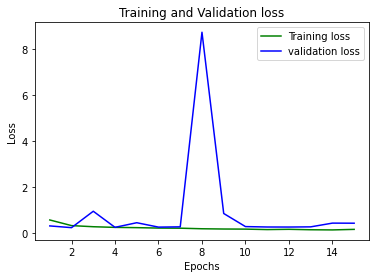

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,16)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

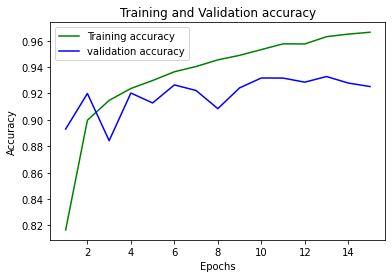

In [35]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,16)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [37]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
    
model.save_weights(filepath='model_weights/cnn_model_wt.h5', overwrite=True)

In [38]:
model = create_cnn_architecture_model(input_shape=INPUT_SHAPE_RN)
model.load_weights('model_weights/cnn_model_wt.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [39]:
test_images_3ch_scaled = test_images_3ch / 255.
predictions = model.predict(test_images_3ch_scaled)
predictions[:5]

array([[6.5612745e-12, 2.0990115e-18, 2.0141445e-12, 2.5660574e-12,
        8.5140124e-12, 4.9643405e-09, 1.4982497e-09, 2.3063631e-06,
        6.4241489e-13, 9.9999774e-01],
       [1.8664713e-06, 6.9160524e-15, 9.9990046e-01, 8.3253369e-09,
        6.6528141e-06, 5.8859851e-13, 9.1016787e-05, 9.4270709e-11,
        5.8533170e-13, 4.8274258e-12],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [7.7083330e-21, 1.0000000e+00, 4.9027036e-22, 1.5791967e-16,
        2.3491193e-18, 8.1295059e-24, 6.1921045e-18, 7.2092849e-20,
        1.6815870e-21, 3.2408246e-21],
       [3.6254882e-05, 4.3449267e-16, 3.6646177e-06, 4.1656168e-08,
        1.7236915e-05, 4.4979537e-14, 9.9994278e-01, 2.3063019e-12,
        3.6026051e-13, 2.5452392e-12]], dtype=float32)

In [40]:
prediction_labels = np.argmax(predictions, axis=1)
print(classification_report(test_labels, prediction_labels, target_names=class_names))
pd.DataFrame(confusion_matrix(test_labels, prediction_labels), index=class_names, columns=class_names)

              precision    recall  f1-score   support

 T-shirt/top       0.91      0.81      0.86      1000
     Trouser       1.00      0.99      0.99      1000
    Pullover       0.91      0.86      0.88      1000
       Dress       0.93      0.92      0.93      1000
        Coat       0.87      0.88      0.87      1000
      Sandal       0.94      0.98      0.96      1000
       Shirt       0.70      0.83      0.76      1000
     Sneaker       0.95      0.98      0.97      1000
         Bag       0.98      0.97      0.97      1000
  Ankle boot       0.98      0.92      0.95      1000

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,808,0,16,12,2,0,157,0,5,0
Trouser,1,986,0,6,2,0,4,0,1,0
Pullover,9,1,858,5,53,0,73,0,1,0
Dress,9,2,5,919,24,0,39,0,2,0
Coat,0,1,25,21,878,0,71,0,4,0
Sandal,0,0,0,0,0,980,0,11,1,8
Shirt,58,0,37,22,53,0,826,0,4,0
Sneaker,0,0,0,0,0,6,0,984,0,10
Bag,1,0,0,2,2,24,2,1,967,1
Ankle boot,0,0,0,0,0,36,1,39,0,924
